<a href="https://colab.research.google.com/github/max1nehour/Carotid-Artery-Image-Classification-Model/blob/main/DenseNet_RCCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Before
# some_tensor = torch.randn(1000, 1000).cuda()
# # Perform operations
# del some_tensor
# # Assume some tensor
# del tensor_variable  # Delete the tensor

# # After
# torch.cuda.empty_cache()

import torch
import gc

gc.collect()  # Manually run garbage collection
torch.cuda.empty_cache()  # Then clear the GPU cache
torch.cuda.reset_max_memory_allocated()
torch.cuda.reset_max_memory_cached()

# Check memory allocated in bytes
print(f"Memory Allocated: {torch.cuda.memory_allocated()} bytes")
# Check memory reserved in bytes
print(f"Memory Reserved: {torch.cuda.memory_reserved()} bytes")


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Memory Allocated: 0 bytes
Memory Reserved: 0 bytes


/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torch/cuda/memory.py:308: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [ ]:
import logging
import sys
import pydicom
from sklearn.metrics import classification_report
import cv2
from os import listdir
import pandas as pd
import os
import shutil
import tempfile
import imghdr

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from torch.utils.data import Dataset, DataLoader
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType
)

from monai.utils import set_determinism
from sklearn.model_selection import train_test_split

def find_plaque(text):
    return 1 if 'plaque' in text else 0

def show_img(title, img):
    plt.title('{}'.format(title))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def create_image_path(dir, row):
    patient_path = os.path.join(dir, row['Patient_ID']) #(dir)/mount/src/summer2024/CAU + (patient_id) /P000051
    image_path = os.path.join(patient_path, row['IMG_ID']+'.jpg') # /mount/src/summer2024/CAU/P000051/IMG0004　(IMG_ID)
    return image_path

############################# 定義 #####################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

#############################################################################################################
df = pd.read_csv('labeled_combined/RCCA.csv')

############### 資料欄位前處理 ##############################
df['頸超總結'] = df['頸超總結'].astype(str)
df['Plaque'] = df['頸超總結'].apply(find_plaque) #建立斑塊欄位 套用寫好的寒士
df['右CCA斑塊'] = df['右CCA斑塊'].replace({'無明顯異常': 0, '無明顯斑塊': 0, '無': 0, '+': 1}) #把中文標記改掉
df['右CCA斑塊'] = df['右CCA斑塊'].apply(lambda x: 1 if pd.notna(x) and x != 0 else 0) #不等於零或無 就等於1

df = df[df['右CCA正常與否'] != 1.5] #拿掉異常直1.5
df['右CCA正常與否'] = df['右CCA正常與否'].replace('正常', 'N').replace('異常', 'A') #更改種文標記

df_normal = df[df['右CCA斑塊'] == 0]
df_abnormal = df[df['右CCA斑塊'] == 1]

#設定root dir
normdir ='/mount/src/RCCA JPG/CAU/Normal'
abnormdir ='/mount/src/RCCA JPG/CAU/Abnormal'
#利用create_image_path 創造路徑欄位
df_normal['norm_path'] = df_normal.apply(lambda row: create_image_path(normdir, row), axis=1)
df_abnormal['abnorm_path'] = df_abnormal.apply(lambda row: create_image_path(abnormdir, row), axis=1)

###轉成列表###
norm_path = df_normal['norm_path'].tolist()
abnorm_path =df_abnormal['abnorm_path'].tolist()

norm_labels = [0] * len(norm_path)
abnorm_labels = [1] * len(abnorm_path)

all_paths = norm_path + abnorm_path
all_labels = norm_labels + abnorm_labels

#用PIL 查看影像長寬 資料總數 各分類有幾個
image_width, image_height = PIL.Image.open(norm_path[0]).size
print(f"Total image count:{len(norm_path)+len(abnorm_path)}")
print(f"Image Dimensions: {image_width} x {image_height}")
print(f"Label counts (0:1): {len(norm_labels)} : {len(abnorm_labels)}")



MONAI version: 1.0.1
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8271a193229fe4437026185e218d5b06f7c8ce69
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

Total image count:55362
Image Dimensions: 816 x 614
Label counts (0:1): 47187 : 8175



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


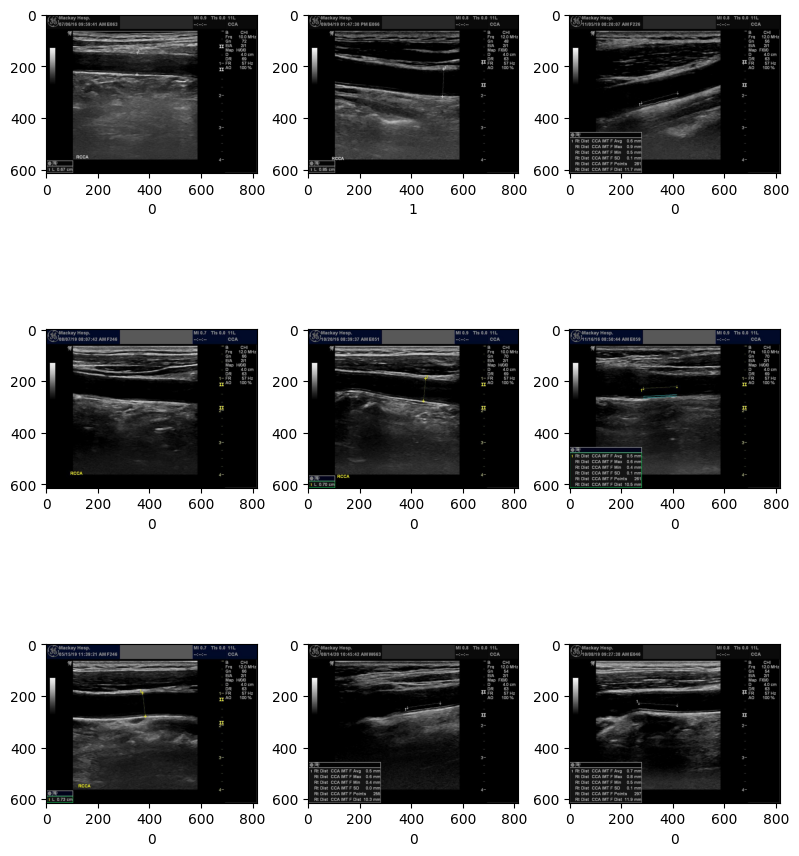

In [ ]:
#########################影像前處理 函式################################
def crop_image(image, x, y, w, h):
    return image[y:y+h, x:x+w]

def center_crop(image, target_height, target_width):
    height, width, _ = image.shape
    start_x = (width - target_width) // 2
    start_y = (height - target_height) // 2
    return image[start_y:start_y + target_height, start_x:start_x + target_width]

def load_dicom_image(filepath, target_size):
    dicom = pydicom.dcmread(filepath)
    dicom_image = dicom.pixel_array
    element = dicom.ImageType[3]
    if str(element) != '0001':
        ultrasound_seg, waveform_seg = segment_image(dicom_image)
        dicom_image = ultrasound_seg

        if dicom_image.ndim == 2:
            dicom_image = np.stack([dicom_image] * 3, axis=-1)
        dicom_image = crop_image(dicom_image, 220, 62, 244, 286)
    else:
        if dicom_image.ndim == 2:
            dicom_image = np.stack([dicom_image] * 3, axis=-1)
        dicom_image = crop_image(dicom_image, 100, 62, 548, 510)

    dicom_image = Resize(spatial_size=(target_size, target_size))(dicom_image)
    dicom_image = dicom_image / 255.0
    print("Processed image shape:", dicom_image.shape)

    img_id = filepath[-7:]
    patient_id = filepath[-16:-8]
    label_idx = df.index[(df['IMG_ID'] == str(img_id)) & (df['Patient_ID'] == str(patient_id))]
    label = df.loc[label_idx, '右CCA斑塊'].values[0]
    return dicom_image

#隨機挑選幾張影像 檢查
plt.subplots(3, 3, figsize=(8, 10))
for i, k in enumerate(np.random.randint(len(all_labels), size=9)):
    im = PIL.Image.open(all_paths[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(all_labels[k])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
#TRAIN/VAL/TEST 分割

train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(all_paths)),
                                                            all_labels,(8,1,1), shuffle = True)
X_train = [all_paths[i] for i in train_inds]
y_train = [all_labels[i] for i in train_inds]
X_val = [all_paths[i] for i in val_inds]
y_val = [all_labels[i] for i in val_inds]
X_test = [all_paths[i] for i in test_inds]
y_test = [all_labels[i] for i in test_inds]
print(f"Training count: {len(X_train)}, Validation count: {len(X_val)}, Test count: {len(X_test)}")

##############Define Transforms #####################
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

act = Compose([EnsureType(), Activations(softmax=True)])
to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

################# Load data ##################
batch_size = 25
num_workers = 4

class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image = self.transforms(self.image_files[index])
        label = self.labels[index]
        #print(image.shape, label)
        # Ensure the image is of shape [channels, height, width]
        if len(image.shape) == 4:
            image = image[:, :, :, 0]
            #image = image.squeeze(0)
        #print(f"\nImage shape in __getitem__: {image.shape}")  # Print shape here
        return image, label

train_ds = Dataset(X_train, y_train, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = Dataset(X_val, y_val, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = Dataset(X_test, y_test, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
# train_ds = ImageDataset(image_files=train_paths, labels=train_labels, transform=train_transforms)
# train_loader = DataLoader(train_ds, batch_size=32, num_workers=2, shuffle=True, pin_memory=torch.cuda.is_available())
# print('trainload',train_loader)
# val_ds = ImageDataset(image_files=val_paths, labels=val_labels, transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=32, num_workers=2, pin_memory=torch.cuda.is_available())

######################Define Network and model ##########################
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)

############################# Train ####################################
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()

        # run the network forwards
        outputs = net(inputs)

        # run the loss function on the outputs
        loss = loss_function(outputs, labels)

        # compute the gradients
        loss.backward()

        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1
        gc.collect()
        torch.cuda.empty_cache()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out

    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y)]
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]

        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)

        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)

        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")

        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


KeyboardInterrupt



In [ ]:
##############################Evaluation#########################
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

################ classification report ###############
net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)

        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

################ confusion matrix #####################

from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()